# Loading example datasets

In this tutorial, you will find the code required to load a few chemistry and materials science datasets.

All datasets will be loaded as [PyTorch dataset objects](https://pytorch.org/docs/stable/data.html).

In [1]:
import torch
from rdkit import Chem
from torch.utils.data import Dataset

## Real data

First, how to load standard datasets for chemistry and materials science.

### QM9

The QM9 dataset, containing energies and other properties of small organic molecules, is included as an example dataset in Pytorch Geometric.
Beware: Running this code will download the entire data set to the specified directory (unless it has already been downloaded).

In [2]:
from torch_geometric import datasets
# The PyTorch dataset
qm9 = datasets.QM9("~/qm9")
# The raw rdkit molecules
qm9_raw = Chem.SDMolSupplier(qm9.raw_paths[0], removeHs=True, sanitize=True)

Taking a look at an entry in the dataset:

In [3]:
gdb1 = next(iter(qm9))
gdb1_raw = next(iter(qm9_raw))

This entry is, in fact, methane:

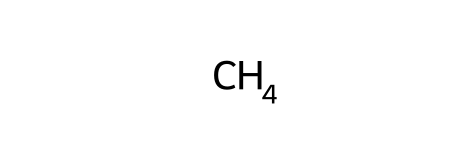

In [4]:
gdb1_raw

Looking at a record in the PyTorch dataset object:

In [5]:
gdb1

Data(edge_attr=[8, 4], edge_index=[2, 8], idx=[1], name="gdb_1", pos=[5, 3], x=[5, 11], y=[1, 19], z=[5])

Considered as a graph, the bonds are in the "edge_index" attribute (2 rows for start and end atom, 8 edges since each bond is represented as an edge in each direction):

In [6]:
gdb1["edge_index"]

tensor([[0, 0, 0, 0, 1, 2, 3, 4],
        [1, 2, 3, 4, 0, 0, 0, 0]])

Considered as an object in 3D space, the positions of the atoms are in the "pos" attribute (5 atoms, 3 dimensions):

In [7]:
gdb1["pos"]

tensor([[-1.2700e-02,  1.0858e+00,  8.0000e-03],
        [ 2.2000e-03, -6.0000e-03,  2.0000e-03],
        [ 1.0117e+00,  1.4638e+00,  3.0000e-04],
        [-5.4080e-01,  1.4475e+00, -8.7660e-01],
        [-5.2380e-01,  1.4379e+00,  9.0640e-01]])

Atom features (including element) are contained in the "x" attribute (5x11: 5 atoms, 11 features). The meanings of the features are in table 1 of [Gilmer et al (2017). Neural Message Passing for Quantum Chemistry](http://proceedings.mlr.press/v70/gilmer17a). The properties to be predicted are contained in the "y" attribute (1x19: a list of 19 properties). There are 19 of them, and their meanings are explained [in the PyTorch geometric documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.QM9).

### Materials Project

The Materials Project is an online database of crystal structures and computed properties.

Thankfully, materials can be downloaded one at a time, unlike molecules in QM9. However, you will need to make an account on the [Materials Project website](https://materialsproject.org/), and then click the "API" button on the top menu to obtain an API key (or click [here](https://materialsproject.org/open)).

Then, the following class can be used to create PyTorch datasets containing materials project entries:

In [8]:
from pymatgen.ext.matproj import MPRester

# Enter your API key here
downloader = MPRester("")

class MPData(Dataset):

    def __init__(self, ids, downloader):
        self.entries = \
            [downloader.get_entry_by_material_id(
                material_id,
                inc_structure = "final",
                conventional_unit_cell = True
             ) 
             for material_id in ids]

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, i):
        # Documentation on the structure of records:
        # https://pymatgen.org/pymatgen.core.html
        entry = self.entries[i]
        structure = entry.structure
        element_Z = [i.Z for i in structure.species]
        return (torch.tensor(element_Z), torch.tensor(structure.frac_coords), torch.tensor(entry.energy))


To create a data set, you need a list of Materials Project IDs, which you can obtain from a Materials Project search, there through their python API or just by [using their search interface in a web browser](https://materialsproject.org/#search/materials/). Below, I create a dataset containing a single entry just so we can see how it is structured:

In [9]:
example_dataset = MPData(["mp-22862"], downloader)
mp22862 = next(iter(example_dataset))
mp22862

/Users/alexdavis/anaconda3/envs/chem/lib/python3.7/site-packages/pymatgen/ext/matproj.py:583: FutureWarning: __init__ is deprecated
MaterialsProjectCompatibility will be updated with new correction classes as well as new values of corrections and uncertainties in 2020
  entries = MaterialsProjectCompatibility().process_entries(entries)


(tensor([11, 11, 11, 11, 17, 17, 17, 17]),
 tensor([[0.0000, 0.0000, 0.0000],
         [0.0000, 0.5000, 0.5000],
         [0.5000, 0.0000, 0.5000],
         [0.5000, 0.5000, 0.0000],
         [0.5000, 0.0000, 0.0000],
         [0.5000, 0.5000, 0.5000],
         [0.0000, 0.0000, 0.5000],
         [0.0000, 0.5000, 0.0000]], dtype=torch.float64),
 tensor(-27.1051))

The three fields are the atomic numbers, the fractional coordinates, and the energy.

This entry is, in fact, table salt.

## Simple exercises

In this section are simple examples. A working definition of "simple" is that the energy can be calculated live when the dataset is created, rather than being precomputed.

### A 4x4 Ising model

In [10]:
import random
import torch
import itertools
from torch.utils.data import Dataset, DataLoader

# Construct edge list for Ising model graph
# 4x4 grid:
size = 4
edge_set = set()
# Convert coordinates in a 2x2 grid to an index in a list formed by
# concatenating rows
def coordsToIndex(i, j):
    return size * i + j

for i, j in itertools.product(range(size), range(size)):
    # Right
    # Need to check if j+1 is off the grid, and equal to size is off the grid
    # because of zero indexing
    if j + 1 < size:
        edge_set.add((coordsToIndex(i, j), coordsToIndex(i, j+1)))
    # Top
    if i > 0:
        edge_set.add((coordsToIndex(i, j), coordsToIndex(i-1, j)))
    # Left
    if j > 0:
        edge_set.add((coordsToIndex(i, j), coordsToIndex(i, j-1)))
    # Bottom
    if i + 1 < size:
        edge_set.add((coordsToIndex(i, j), coordsToIndex(i+1, j)))

# Tensor of edges
edges = torch.tensor(list(edge_set), dtype = torch.int64)

class RandomSpins(Dataset):
    def __init__(self, nrow):
        # Integer tensor with two columns listing the edges, used for
        # calculating energy
        self.edges = edges
        # Number of nodes in the Ising model
        self.nnode = int(size**2)
        # Size of the virtual data set (number of distinct spin
        # configurations). Basically arbitrary
        self.nrow = int(nrow)

    def __len__(self):
        return self.nrow

    def __getitem__(self, i):
        if i < 0:
            raise IndexError("Negative index")
        if i >= self.nrow:
            raise IndexError("Index out of bounds of virtual dataset")
        random.seed(i)
        spins = torch.tensor([random.choice([-1, 1]) for i in range(self.nnode)], dtype = torch.float64)
        left_spins = spins[self.edges[:,0]]
        right_spins = spins[self.edges[:,1]]
        # Ferromagnetic case: aligned spins is low energy, multiply by -1
        energy = - 1 * left_spins.dot(right_spins)
        return (spins.reshape((size,size)), energy)


Initializing a dataset requires a single argument, the dataset size:

In [11]:
spin_dataset = RandomSpins(1000)

Each record contains a 4x4 grid of spins (either +1 or -1), as well as an energy (-1 * product of spins for all neighboring pairs):

In [12]:
next(iter(spin_dataset))

(tensor([[ 1.,  1., -1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [ 1., -1., -1.,  1.],
         [-1., -1.,  1., -1.]], dtype=torch.float64),
 tensor(-0., dtype=torch.float64))

The spins are random and generated independently, which tends to concentrate them in a relatively narrow band of energies.